In [193]:
import matplotlib as mpl
from numpy import dtype

from ecoli.variants.new_gene_internal_shift import get_new_gene_ids_and_indices

mpl.rcParams['figure.dpi'] = 150

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
from textwrap import wrap

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2", context="paper")
warnings.filterwarnings(action='ignore')

RELOAD_ACCESSION_DATA = False

## import conversion table

In [194]:
conversion_df = pl.read_csv("external_data/metalloproteome_exp_conversion.csv")

# get all unique values of End and Index
end_values = conversion_df["End"].unique().to_list()
index_values = conversion_df["Index"].unique().to_list()

# give each unique value a unique number
end_dict = {end: i for i, end in enumerate(end_values)}
index_dict = {index: i for i, index in enumerate(index_values)}

# create a new column for the unique value
conversion_df = conversion_df.with_columns(x=pl.col("End").replace(end_dict))
conversion_df = conversion_df.with_columns(y=pl.col("Index").replace(index_dict))

# drop start end index
conversion_df = conversion_df.drop(["Start", "End", "Index"])

conversion_df

Experiment,x,y
str,i64,i64
"""0to0_1""",0,0
"""0to0_2""",0,1
"""0to0_3""",0,2
"""0to0_4""",0,3
"""0to0_5""",0,4
…,…,…
"""900to1000_28""",17,27
"""900to1000_29""",17,28
"""900to1000_30""",17,29



## Import protein data

In [196]:
import requests
import xml.etree.ElementTree as ET
import time

if RELOAD_ACCESSION_DATA:
    for accession_id in prot_df["Accession Number"]:
        
        if accession_id not in gene_dict:
            # add a 0.1 second delay between each request
            time.sleep(1)
            
            # Step 1: Use elink to find the Gene ID associated with the protein accession
            elink_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=protein&db=gene&id={accession_id}&retmode=xml"
            elink_response = requests.get(elink_url)
            elink_tree = ET.fromstring(elink_response.content)
            
            # Extract the Gene ID from the elink response
            gene_id = None
            for linkset in elink_tree.findall(".//LinkSetDb"):
                if linkset.find("LinkName").text == "protein_gene" and linkset.find(".//Id") is not None:
                    gene_id = linkset.find(".//Id").text
                    break
            
            # Step 2: Use esummary to get the gene information based on the Gene ID
            if gene_id:
                esummary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={gene_id}&retmode=xml"
                esummary_response = requests.get(esummary_url, headers=headers)
                esummary_tree = ET.fromstring(esummary_response.content)
                
                # Extract the gene name
                gene_name = esummary_tree.find(".//Name").text
                print(f"Gene name: {gene_name}")
            else:
                print("Gene ID not found.")
                
            gene_dict[accession_id] = gene_name

In [197]:
# load gene df
gene_df = pl.read_csv("data/accession_gene_dict.csv")
gene_df

# convert to dict
gene_dict = dict(zip(gene_df["Accession Number"], gene_df["Gene Name"]))

gene_df

Accession Number,Gene Name
str,str
"""AAC76954.1""","""tufB"""
"""AAC76345.1""","""rplC"""
"""AAC76328.1""","""rpsE"""
"""AAC74990.1""","""fliC"""
"""AAC77103.1""","""groL"""
…,…
"""AAC75718.1""","""ygaC"""
"""AAC73987.1""","""ycaK"""
"""AAC77128.1""","""miaA"""


## Change column to gene name

In [243]:
# Load the data
prot_df = pl.read_csv('external_data/metalloproteome_proteins.csv')

# drop "#", "Visible?", "Starred?", "Molecular Weight"
prot_df = prot_df.drop(["#", "Visible?", "Starred?", "Molecular Weight", "Taxonomy"])

prot_df.head(5)

# change column to gene name
prot_df = prot_df.with_columns(Gene=pl.col("Accession Number").replace(gene_dict))

# drop Identified Proteins (1235), Accession Number
prot_df = prot_df.drop(["Identified Proteins (1235)", "Accession Number"])

# drop duplicate rows with the same gene name
prot_df = prot_df.unique(subset=["Gene"], maintain_order=True)

# transpose and keep gene as column names
prot_exp_names = list(prot_df.columns)[:-1]
gene_names = prot_df["Gene"].to_list()

In [244]:
# transpose and keep gene as column names
prot_df = prot_df.drop(["Gene"]).transpose()
prot_df.columns = gene_names

# add a new column, "Experiment"
prot_df = prot_df.with_columns(pl.Series(name="Experiment", values=prot_exp_names))

# join with the conversion table
prot_df = prot_df.join(conversion_df, on="Experiment")

prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_1""",0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_2""",0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_3""",0,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_4""",0,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_5""",0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_28""",17,27
0,0,6,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_29""",17,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_30""",17,29


## Load the metal data

In [286]:
# load metal data
metal_df = pl.read_csv('external_data/metalloproteome_metals.csv')

# drop columns that started with "_dupli"
metal_df = metal_df.drop([col for col in metal_df.columns if col.startswith("_dupli")])

# drop columns without names
metal_df = metal_df.drop([col for col in metal_df.columns if len(col) < 2])

metal_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0to0_1""",86.974396,4.004968,5.167747,0.179796,0.876813,10.836837,10.552461,10.337697,0.057026,1.173599,0.500182,0.602304,0.0222,0.119779,0.117428,0.00104,-13.836556,0.09528,0.007665,40.403296,3.449361,0.016148,9.993649
"""0to0_2""",1.353013,0.095871,0.377731,0.108823,0.728478,6.006004,2.958434,2.69667,0.048106,1.077893,0.339914,0.524031,0.013567,0.299447,0.117188,0.000208,-13.536126,0.056937,0.007508,35.564532,2.891377,0.010286,10.862665
"""0to0_3""",1.516522,0.100229,0.403266,0.116908,0.722591,5.784571,3.121333,2.888219,0.056345,1.111941,0.300745,0.542167,0.013567,0.059889,0.114162,0.00104,-13.595515,0.044946,0.007039,37.500017,2.536294,0.00858,9.993649
"""0to0_4""",1.600319,0.082798,0.414614,0.112477,0.746018,5.556133,3.373253,3.177696,0.080347,1.251426,0.30058,0.603577,0.0259,0.029945,0.126954,0.001873,-13.555307,0.037981,0.006804,39.193624,2.58702,0.007826,8.907374
"""0to0_5""",1.671855,0.069725,0.442581,0.117996,0.789342,5.53877,3.598385,3.239036,0.10545,1.430548,0.480732,0.702853,0.024667,0.239558,0.11815,0.002289,-13.657827,0.037335,0.009229,43.548493,3.347909,0.011981,8.255623
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",1.099329,0.082724,0.189697,0.114594,0.271328,0.044113,1.119198,0.83295,0.006293,0.169676,0.18,0.172763,0.014881,0.159694,0.073712,0.0,-15.342357,0.021587,0.00541,18.588133,1.491532,0.003633,3.698081
"""900to1000_29""",1.144876,0.078128,0.171669,0.112909,0.262306,0.041008,1.146955,0.85173,0.006668,0.180365,0.176192,0.168419,0.017362,0.031939,0.076596,0.000631,-15.345479,0.023709,0.004199,22.796756,1.789838,0.003382,4.88147
"""900to1000_30""",1.115892,0.045958,0.195433,0.108098,0.225865,0.070682,1.009749,0.69928,0.00599,0.202633,0.174884,0.269673,0.019842,0.127755,0.074627,0.000421,-15.180415,0.022758,0.004441,16.133086,2.336734,0.004481,4.141853


<Axes: ylabel='66Zn'>

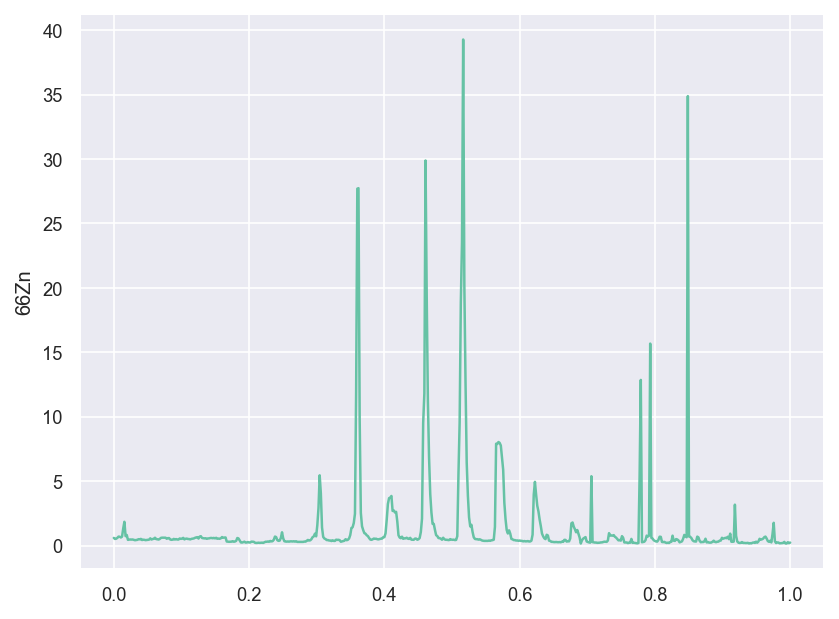

In [287]:
n_samples  = metal_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_df)

# Join the metalloproteome data with the conversion table

In [288]:
# join the data
metal_join_df = metal_df.join(conversion_df, on="Experiment")

metal_join_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""0to0_1""",86.974396,4.004968,5.167747,0.179796,0.876813,10.836837,10.552461,10.337697,0.057026,1.173599,0.500182,0.602304,0.0222,0.119779,0.117428,0.00104,-13.836556,0.09528,0.007665,40.403296,3.449361,0.016148,9.993649,0,0
"""0to0_2""",1.353013,0.095871,0.377731,0.108823,0.728478,6.006004,2.958434,2.69667,0.048106,1.077893,0.339914,0.524031,0.013567,0.299447,0.117188,0.000208,-13.536126,0.056937,0.007508,35.564532,2.891377,0.010286,10.862665,0,1
"""0to0_3""",1.516522,0.100229,0.403266,0.116908,0.722591,5.784571,3.121333,2.888219,0.056345,1.111941,0.300745,0.542167,0.013567,0.059889,0.114162,0.00104,-13.595515,0.044946,0.007039,37.500017,2.536294,0.00858,9.993649,0,2
"""0to0_4""",1.600319,0.082798,0.414614,0.112477,0.746018,5.556133,3.373253,3.177696,0.080347,1.251426,0.30058,0.603577,0.0259,0.029945,0.126954,0.001873,-13.555307,0.037981,0.006804,39.193624,2.58702,0.007826,8.907374,0,3
"""0to0_5""",1.671855,0.069725,0.442581,0.117996,0.789342,5.53877,3.598385,3.239036,0.10545,1.430548,0.480732,0.702853,0.024667,0.239558,0.11815,0.002289,-13.657827,0.037335,0.009229,43.548493,3.347909,0.011981,8.255623,0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",1.099329,0.082724,0.189697,0.114594,0.271328,0.044113,1.119198,0.83295,0.006293,0.169676,0.18,0.172763,0.014881,0.159694,0.073712,0.0,-15.342357,0.021587,0.00541,18.588133,1.491532,0.003633,3.698081,17,27
"""900to1000_29""",1.144876,0.078128,0.171669,0.112909,0.262306,0.041008,1.146955,0.85173,0.006668,0.180365,0.176192,0.168419,0.017362,0.031939,0.076596,0.000631,-15.345479,0.023709,0.004199,22.796756,1.789838,0.003382,4.88147,17,28
"""900to1000_30""",1.115892,0.045958,0.195433,0.108098,0.225865,0.070682,1.009749,0.69928,0.00599,0.202633,0.174884,0.269673,0.019842,0.127755,0.074627,0.000421,-15.180415,0.022758,0.004441,16.133086,2.336734,0.004481,4.141853,17,29


<Axes: >

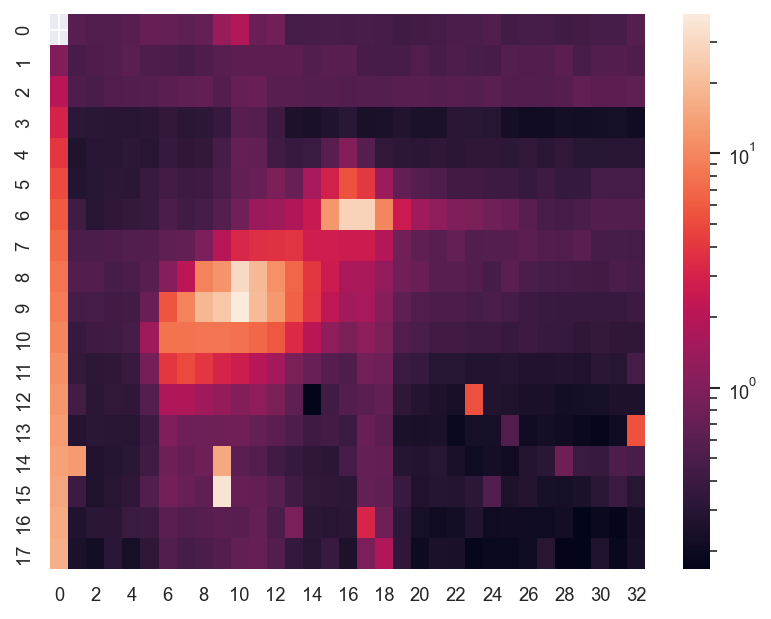

In [294]:
from matplotlib.colors import LogNorm

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", ), norm=LogNorm())

# log


<Axes: >

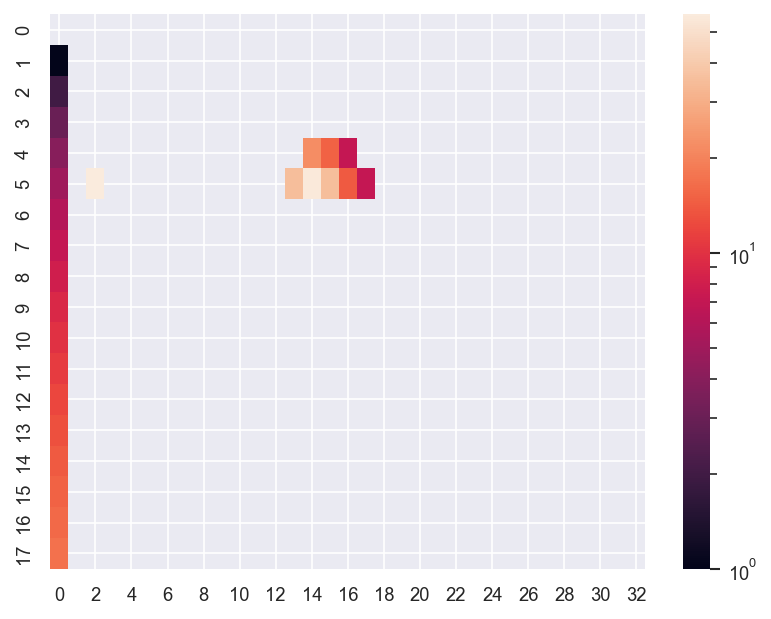

In [293]:
sns.heatmap(prot_df.pivot("modA", "x", "y", ), norm=LogNorm())

In [291]:
# check if mo is in any gene name
mo_genes = [gene for gene in gene_names if "mo" in gene]
mo_genes

['modA',
 'modF',
 'moeA',
 'mog',
 'motB',
 'moaE',
 'cmoA',
 'moaC',
 'mobB',
 'modE',
 'cmoM']

<Axes: ylabel='95Mo'>

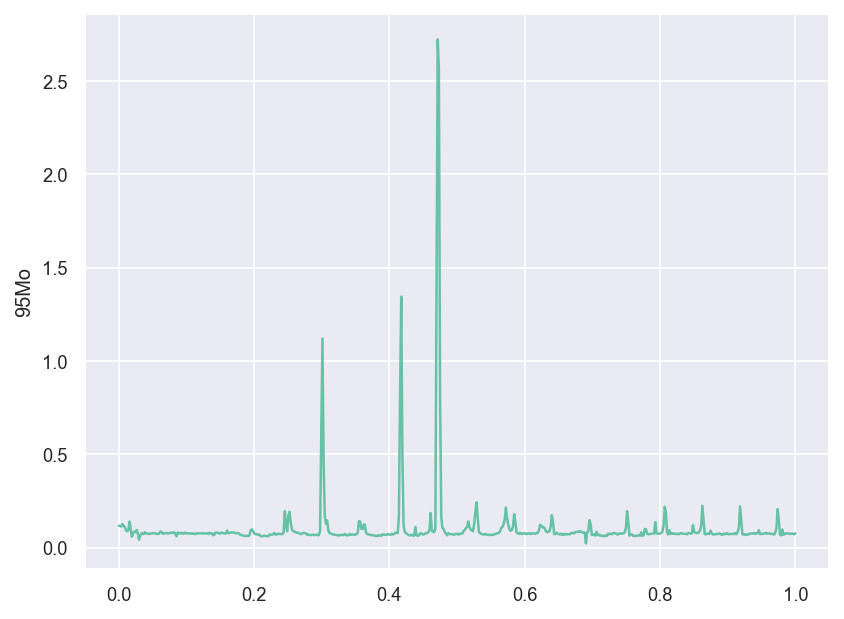

In [292]:
# plot log of Zn as line plot
sns.lineplot(x=linspace, y="95Mo", data=metal_df)
